In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Horse Breeds",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 75 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Arabian', 'Clydesdale', 'Friesian', 'Shetland Pony']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 3 2 0 2 1 3 1 0 3 2 2 0 1 1 1 0 1 3 3 0 3 2 3 0 3 3 0 0 2 3 2]


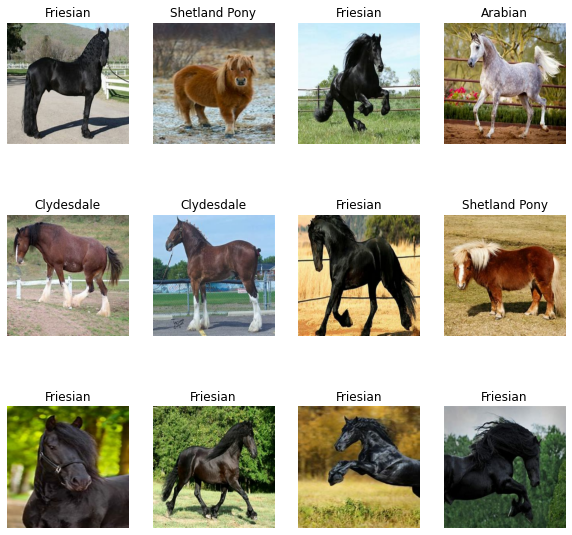

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

3

In [8]:
train_size = 0.8
len(dataset)*train_size

2.4000000000000004

In [9]:
train_ds = dataset.take(54)
len(train_ds)

3

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

0.30000000000000004

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

2

In [17]:
len(val_ds)

0

In [18]:
len(test_ds)

1

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
2/2 [==============================] - 6s 2s/step - loss: 1.3927 - accuracy: 0.3125
Epoch 2/50
2/2 [==============================] - 5s 2s/step - loss: 1.3683 - accuracy: 0.3125
Epoch 3/50
2/2 [==============================] - 5s 2s/step - loss: 1.3632 - accuracy: 0.3125
Epoch 4/50
2/2 [==============================] - 5s 2s/step - loss: 1.3563 - accuracy: 0.3125
Epoch 5/50
2/2 [==============================] - 6s 2s/step - loss: 1.3410 - accuracy: 0.3125
Epoch 6/50
2/2 [==============================] - 5s 2s/step - loss: 1.3200 - accuracy: 0.3125
Epoch 7/50
2/2 [==============================] - 5s 2s/step - loss: 1.3082 - accuracy: 0.3125
Epoch 8/50
2/2 [==============================] - 5s 2s/step - loss: 1.2902 - accuracy: 0.4219
Epoch 9/50
2/2 [==============================] - 5s 2s/step - loss: 1.2427 - accuracy: 0.3594
Epoch 10/50
2/2 [==============================] - 5s 2s/step - loss: 1.2174 - accuracy: 0.4219
Epoch 11/50
2/2 [==============================] 

In [27]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 1s 638ms/step - loss: 0.2216 - accuracy: 0.9091


In [28]:
scores

[0.22161675989627838, 0.9090909361839294]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 2}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.3926608562469482,
 1.368269920349121,
 1.3632049560546875,
 1.3562532663345337,
 1.3409812450408936]

first image to predict
actual label: Friesian
1/1 [==============================] - 0s 338ms/step
predicted label: Friesian


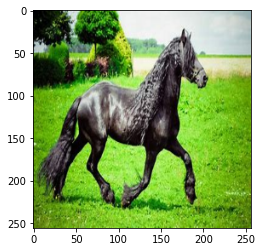

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


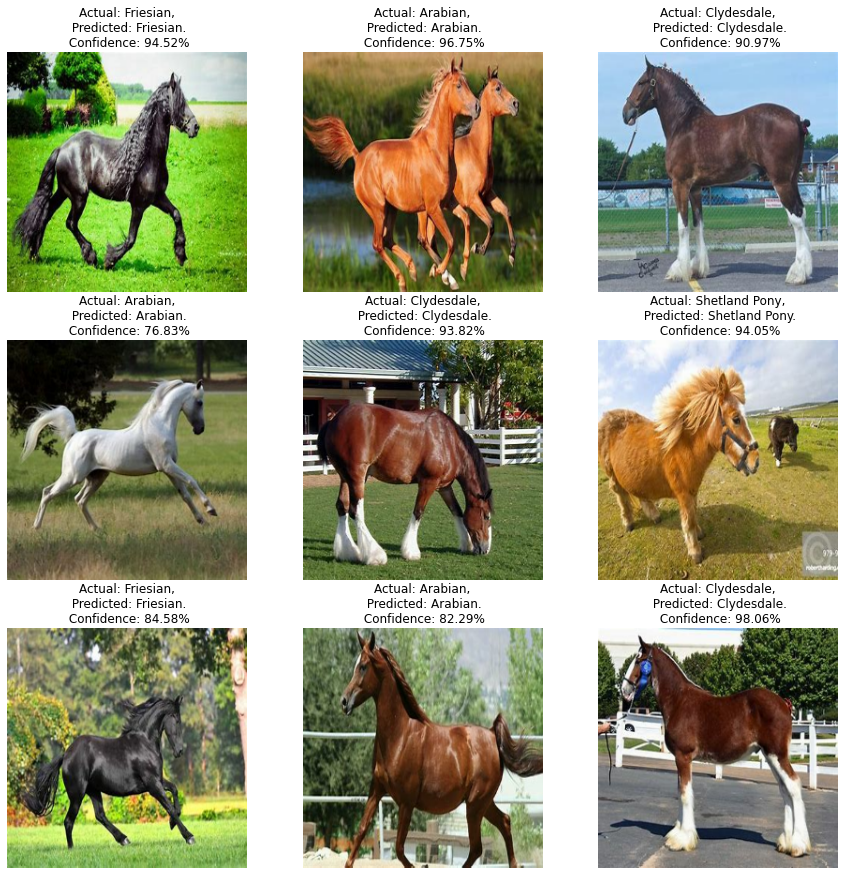

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
model.save('./models', save_format='tf')

In [39]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.8 MB 26.9 MB/s 
     |████████████████████████████████| 278 kB 63.9 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 2.3 MB 61.3 MB/s 
     |████████████████████████████████| 106 kB 66.1 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 80 kB 10.1 MB/s 
     |████████████████████████████████| 68 kB 9.2 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4711 sha256=f07bec5e697e5195bc7f18621a2235cd2d4c49f4faef6ca3d753ab84298090b0
  Stored in dire

In [40]:
import gradio as gr

In [42]:
def predict_image(img):
  img_4d=img.reshape(-1,256,256,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(4)}

In [46]:
image = gr.inputs.Image(shape=(256,256))
label = gr.outputs.Label(num_top_classes=4)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 65ms/step
Keyboard interruption in main thread... closing server.
